In [1]:
import os
import netCDF4

import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature

from matplotlib.collections import LineCollection
from matplotlib.path import Path
import matplotlib.path as mpath
import matplotlib.patches as patches

In [2]:
#################
# Load Data
#################
#Path
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
filename_sfc_T2M = 'Feb2020_Attr_sfc-1950-2020_t2m_24H.nc'
filename_pres_Z = 'Feb2020_Attr_pres-1950-2020_Z500_24H.nc'

#Load netcdf
ncdf_T2M = netCDF4.Dataset(filename_sfc_T2M)
ncdf_Z = netCDF4.Dataset(filename_pres_Z)

#Get dimensions
lons = ncdf_T2M.variables['longitude'][:]
lats = ncdf_T2M.variables['latitude'][:]
times = ncdf_T2M.variables['time'][:]

#Calculate datetime
dtimes = np.empty(len(times), dtype='datetime64[h]')
for i,t in enumerate(times):
    dtimes[i] = np.datetime64('1900-01-01') + np.timedelta64(np.int64(t),'h')
dtimes = dtimes.astype('datetime64')

#Get variables
t2m = ncdf_T2M.variables['t2m'][:,:,:]-273.15
z = ncdf_Z.variables['z'][:,:,:]/10

In [3]:
#######################################################
#Calculate the percentile of 6 day temperature from 1950-to-2019 and compare with 2020
#######################################################
#Calculate mean Tempearture of Feb 2020 and TClim (mean) of Feb 1950-2019
dtimes_Clim = dtimes[dtimes < np.datetime64('2019-03-01T00:00')]

#Calculate the mean of 6 day temperature from 5-10 Feb 2020
T2m_5day_mean = np.empty((np.size(dtimes_Clim-6), np.size(t2m,1), np.size(t2m,2)))
Z500_5day_mean = np.empty((np.size(dtimes_Clim-6), np.size(z,1), np.size(z,2)))
for i in range(np.size(dtimes_Clim-6)):
    T2m_5day_mean[i,:,:] = np.mean(t2m[i:i+6,:,:], axis=0)
    Z500_5day_mean[i,:,:] = np.mean(z[i:i+6,:,:], axis=0)

#Calculate the mean of 6 day temperature from 6-10 Feb 2020
T2M611Feb_mean = np.mean(t2m[np.where(dtimes == np.datetime64('2020-02-06T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-11T00:00'))[0][0]+1,:,:], axis=0)
Z500611Feb_mean = np.mean(z[np.where(dtimes == np.datetime64('2020-02-06T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-11T00:00'))[0][0]+1,:,:], axis=0)

#Calculate and save the percentile
T2M611Feb_percentile = np.empty((np.size(T2m_5day_mean, 1),np.size(T2m_5day_mean, 2)))
Z500611Feb_percentile = np.empty((np.size(Z500_5day_mean, 1),np.size(Z500_5day_mean, 2)))
for i in range(np.size(T2m_5day_mean, 1)):
    for j in range(np.size(T2m_5day_mean, 2)):
        T2M611Feb_percentile[i,j] = scipy.stats.percentileofscore(T2m_5day_mean[:,i,j], T2M611Feb_mean[i,j])
        Z500611Feb_percentile[i,j] = scipy.stats.percentileofscore(Z500_5day_mean[:,i,j], Z500611Feb_mean[i,j])
np.savetxt('T2M611Feb_percentile_24H.csv', T2M611Feb_percentile, fmt='%.1f', delimiter=';')
np.savetxt('Z500611Feb_percentile_24H.csv', Z500611Feb_percentile, fmt='%.1f', delimiter=';')

In [4]:
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')

T2020 = np.loadtxt('T2020_24H.csv', delimiter=';')
TClim = np.loadtxt('TClim_24H.csv', delimiter=';')
T611Feb = np.loadtxt('T611Feb_24H.csv', delimiter=';')

Z5002020 = np.loadtxt('Z5002020_24H.csv', delimiter=';')
Z500Clim = np.loadtxt('Z500Clim_24H.csv', delimiter=';')
Z500611Feb = np.loadtxt('Z500611Feb_24H.csv', delimiter=';')

T2M611Feb_percentile = np.loadtxt('T2M_611Feb_percentile_24H.csv', delimiter=';')
Z500611Feb_percentile = np.loadtxt('Z500_611Feb_percentile_24H.csv', delimiter=';')
os.chdir('D:\\MEGA\\UBUNTU\\Jupyter\\GRUPOANTARTICO\\Atribution Feb2020')

In [5]:
#Sectors indexs
AP_lons = [-55, -76]
AP_lats = [-62, -70]
AP_ilats = [np.where(lats == AP_lats[0])[0][0],np.where(lats == AP_lats[1])[0][0]]
AP_ilons = [np.where(lons == AP_lons[0])[0][0],np.where(lons == AP_lons[1])[0][0]]

#Calculate weighting matrix
lons_sec_grid_AP, lats_sec_grid_AP = np.meshgrid(lons[AP_ilons[1]:AP_ilons[0]+1], lats[AP_ilats[0]:AP_ilats[1]+1])
weighting_grid_AP = np.sqrt(np.cos(lats_sec_grid_AP*np.pi/180))

In [6]:
#################
# Add Land Sea Mask
#################
#Path
os.chdir('D:\\Bigfiles\\ERA5_Feb2020_Attribution')
filename_sfc_O = 'ERA5_orograpy-lsm.nc'
ncdf_O = netCDF4.Dataset(filename_sfc_O)
lsm = ncdf_O.variables['lsm'][::2]
lsm = lsm[:,::2,::2]
lsm3d = np.repeat(lsm, np.shape(dtimes), axis=0)
t2mm = np.ma.masked_array(t2m, mask=np.logical_not(lsm3d))
#TClimm = np.ma.masked_array(TClim, mask=np.logical_not(lsm_AP))

lsm_AP = lsm[:,AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]
TClimm = np.ma.masked_array(TClim, mask=np.logical_not(lsm))
#TClim_APm = np.ma.masked_array(TClim_AP, mask=np.logical_not(lsm_AP))
weighting_grid_APm = np.ma.masked_array(weighting_grid_AP, mask=np.logical_not(lsm_AP))
T2M611Feb_mean_APm = np.sum(weighting_grid_APm*(T611Feb[AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]-TClimm[AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]))/np.sum(weighting_grid_APm) #mean weighted by sqrt(cos(lat))
T2M611Feb_mean_APm

4.51387400947657

In [8]:
#######################################################
#Calculate the percentile of 6 day temperature from 1950-to-2019 and compare with 2020
#######################################################
#Calculate mean Tempearture of Feb 2020 and TClim (mean) of Feb 1950-2019
dtimes_Clim = dtimes[dtimes < np.datetime64('2019-03-01T00:00')]

#Calculate the mean of 6 day temperature from 5-10 Feb 2020
T2m_6day_meanm = np.empty((np.size(dtimes_Clim-6), np.size(t2mm,1), np.size(t2mm,2)))
for i in range(np.size(dtimes_Clim-6)):
    T2m_6day_meanm[i,:,:] = np.mean(t2mm[i:i+6,:,:], axis=0)

#Calculate the mean of 6 day temperature from 6-10 Feb 2020
T2M611Feb_meanm = np.mean(t2mm[np.where(dtimes == np.datetime64('2020-02-06T00:00'))[0][0]:np.where(dtimes == np.datetime64('2020-02-11T00:00'))[0][0]+1,:,:], axis=0)

#Calculate and save the percentile
#T2M611Feb_percentile = np.empty((np.size(T2m_6day_meanm, 1),np.size(T2m_5day_meanm, 2)))
#for i in range(np.size(T2m_6day_meanm, 1)):
#    for j in range(np.size(T2m_6day_meanm, 2)):
#        T2M611Feb_percentile[i,j] = scipy.stats.percentileofscore(T2m_5day_meanm[:,i,j], T2M611Feb_meanm[i,j])
#np.savetxt('T2M611Feb_percentile_24H.csv', T2M611Feb_percentile, fmt='%.1f', delimiter=';')

In [9]:
#Create dataframe with mean temperature for WA and AP
T2M_6day_mean_AP = np.sum(weighting_grid_APm*(T2m_6day_meanm[:, AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]-TClimm[AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]), axis=(1,2))/np.sum(weighting_grid_APm)
T2M611Feb_mean_AP = np.sum(weighting_grid_APm*(T611Feb[AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]-TClimm[AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]))/np.sum(weighting_grid_APm) #mean weighted by sqrt(cos(lat))

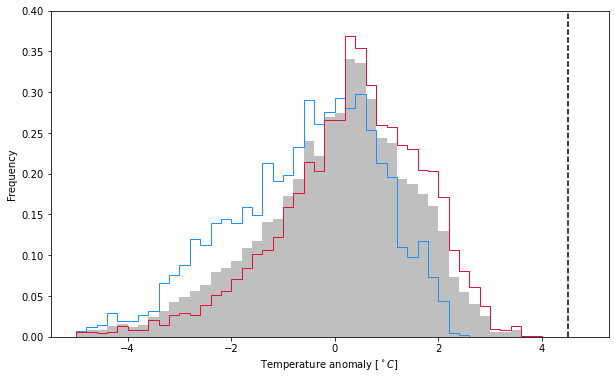

In [11]:
fig, (ax1)  = plt.subplots(1, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10,6), facecolor='white')

ax1.hist(T2M_6day_mean_AP, bins=np.arange(-5,5,0.2), density=True, facecolor='gray', alpha=.5)
ax1.hist(T2M_6day_mean_AP[:2068], bins=np.arange(-5,5,0.2), density=True, histtype='step', color='DodgerBlue')
ax1.hist(T2M_6day_mean_AP[2074:], bins=np.arange(-5,5,0.2), density=True, histtype='step', color='Crimson')
ax1.plot([T2M611Feb_mean_APm,T2M611Feb_mean_APm], [0,1],'k--')
ax1.set_ylim(0,0.4)
ax1.set_xlabel('Temperature anomaly [$^\circ C$]')
ax1.set_ylabel('Frequency')

plt.savefig('ERA5_avgrunningThist_611Feb2020_24H.png')

In [12]:
#Percentile
print(np.percentile(T2M_6day_mean_AP, 90))
print(np.percentile(T2M_6day_mean_AP, 95))
print(np.percentile(T2M_6day_mean_AP, 99))

1.807954748170984
2.137277946685879
2.789383463928681


AP 1950-1984: -0.3678686459205909
AP 1985-2019: 0.39643228042600753
AP Reg: [ 1.8073581e-02 -3.5867574e+01]
0.01807358097749864 -35.86757402754278 9.434826143397745e-07


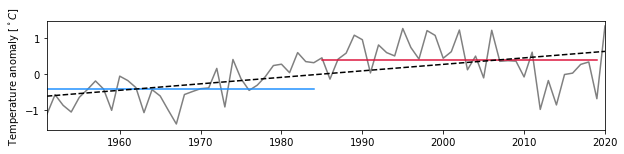

In [18]:
####################
##Plot Feb 2020 Mean Temperatures
####################

#Sectors indexs
#AP_lons = [-55, -76]
#AP_lats = [-63, -70]
#AP_ilats = [np.where(lats == AP_lats[0])[0][0],np.where(lats == AP_lats[1])[0][0]]
#AP_ilons = [np.where(lons == AP_lons[0])[0][0],np.where(lons == AP_lons[1])[0][0]]

#Create dataframe with mean temperature for WA and AP
tmean_AP = np.sum(weighting_grid_APm*(t2mm[:, AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]-TClim[AP_ilats[0]:AP_ilats[1]+1, AP_ilons[1]:AP_ilons[0]+1]), axis=(1,2))/np.sum(weighting_grid_APm)
data = {'Tmean_AP': tmean_AP}
df = pd.DataFrame(data=data, index=dtimes)

years = np.arange(1950,2021)
df_AP_years = df['Tmean_AP'].groupby(df.index.year).mean()

#Plot mean temperature
fig, (ax1)  = plt.subplots(1, 1, sharex=True, gridspec_kw={'hspace': 0}, figsize=(10,2), facecolor='white')

ax1.plot(years, df_AP_years, '-', color='gray')
ax1.plot([1950,1984], [df_AP_years[:35].mean(), df_AP_years[:35].mean()], '-', color='DodgerBlue')
ax1.plot([1985,2019], [df_AP_years[35:-1].mean(), df_AP_years[35:-1].mean()], '-', color='Crimson')
coef = np.polyfit(years[:-1], df_AP_years[:-1].values, 1)
poly1d_fn = np.poly1d(coef) 
ax1.plot(years, poly1d_fn(years), '--k')
ax1.set_xlim(1951,2020)
ax1.set_ylabel('Temperature anomaly [$^\circ C$]')
print('AP 1950-1984: ' + str(df_AP_years[1:35].mean()))
print('AP 1985-2019: ' + str(df_AP_years[35:-1].mean()))
print('AP Reg: ' + str(coef))

slope, intercept, r_value, p_value, std_err = stats.linregress(years[:-1], df_AP_years[:-1].values)
print(slope, intercept, p_value)


#label
#ax1.annotate('ERA5 Antarctic Peninsula Sector', xy=(0.995, 0.05), xycoords='axes fraction', ha='right')

#Saveplot
plt.savefig('ERA5_meanmonthlyT_JanFeb_24H.png')